In [1]:
%cd /home/jovyan/data/vasp-interactive-test/examples/

/home/jovyan/data/vasp-interactive-test/examples


In [2]:
import joblib
from joblib import Memory

In [3]:
from ex10_mlp_online import run_opt, gen_cluster
from dask_kubernetes import KubeCluster
from dask.distributed import Client
import dask.bag as bag

In [4]:
cluster = KubeCluster("worker-cpu-spec-large.yml")
client = Client(cluster)
cluster.adapt(maximum=10)

Creating scheduler pod on cluster. This may take some time.


distributed.deploy.adaptive - INFO - Adaptive scaling started: minimum=0 maximum=10


In [7]:
from pathlib import Path
curdir = Path(".").resolve()
bench_root = curdir / "mlp_cluster_benchmark" / "cache"

In [8]:
memory = Memory(bench_root)

In [9]:
@memory.cache
def gen_cluster_iter(metal, n, i):
    cluster = gen_cluster(metal, n)
    return cluster

In [10]:
@memory.cache
def run_opt_cached(structure, **params):
    """Cached version of results"""
    return run_opt(structure, **params)

In [11]:
def run_benchmark_cluster(metal, n, i):
    """Run 4x cycles"""
    results = dict(metal=metal, n=n)
    initial_structure = gen_cluster_iter(metal, n, i)
    parameters = [dict(vasp="Vasp", use_al=False, store_wf=True),
                 dict(vasp="Vasp", use_al=True, store_wf=True),
                 dict(vasp="VaspInteractive", use_al=True, store_wf=True),
                 dict(vasp="VaspInteractive", use_al=False, store_wf=True)]
    keys = ["vasp+bfgs", "vasp+al", "vpi+bfgs", "vpi+al"]
    param_seq = [param for param in parameters]
    for key, param in zip(keys, parameters):
        try:
            t, steps, fin, _ = run_opt_cached(initial_structure, **param)
            results[key] = dict(t=t, steps=steps, final_image=fin)
        except RuntimeError:
            results[key] = None
    return results

In [22]:
import itertools
cluster_size = range(3, 20, 3)
sample_indices = range(5)
seq = list(itertools.product(["Cu"], cluster_size, sample_indices))


In [23]:


jobs = bag.from_sequence(seq).map(lambda v: run_benchmark_cluster(*v))

In [24]:
jobs

dask.bag<lambda, npartitions=30>

In [25]:
job_done = jobs.compute()

distributed.deploy.adaptive - INFO - Retiring workers [20, 21, 22]
distributed.deploy.adaptive - INFO - Retiring workers [19]


In [ ]:
client.get_worker_logs()

In [ ]:
cluster.close()

In [36]:
job_done

[{'metal': 'Cu',
  'n': 3,
  'vasp+bfgs': {'t': 80.96182131767273,
   'steps': [18, 4, 5],
   'final_image': Atoms(symbols='Cu3', pbc=True, cell=[20.64, 20.088613939370365, 19.080379221529867], calculator=SinglePointCalculator(...))},
  'vasp+al': {'t': 80.3165853023529,
   'steps': [18, 4, 5],
   'final_image': Atoms(symbols='Cu3', pbc=True, cell=[20.64, 20.088613939370365, 19.080379221529867], calculator=SinglePointCalculator(...))},
  'vpi+bfgs': {'t': 53.091108560562134,
   'steps': [18, 3, 3, 1],
   'final_image': Atoms(symbols='Cu3', pbc=True, cell=[20.64, 20.088613939370365, 19.080379221529867], calculator=SinglePointCalculator(...))},
  'vpi+al': {'t': 60.22312927246094,
   'steps': [18, 3, 3, 3, 1],
   'final_image': Atoms(symbols='Cu3', pbc=True, cell=[20.64, 20.088613939370365, 19.080379221529867], calculator=SinglePointCalculator(...))}},
 {'metal': 'Cu',
  'n': 3,
  'vasp+bfgs': {'t': 269.6517868041992,
   'steps': [21, 4, 6],
   'final_image': Atoms(symbols='Cu3', pbc=Tru

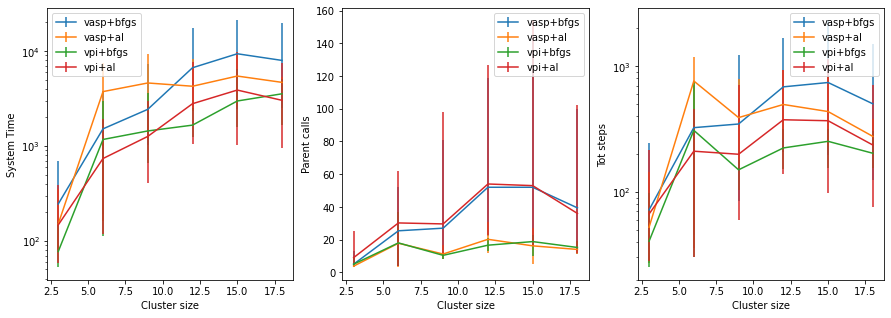

In [58]:
import matplotlib.pyplot as plt
import numpy as np



time = {"vasp+bfgs": {}, "vasp+al": {}, "vpi+bfgs": {}, "vpi+al": {}}
tot_steps = {"vasp+bfgs": {}, "vasp+al": {}, "vpi+bfgs": {}, "vpi+al": {}}
parent_calls = {"vasp+bfgs": {}, "vasp+al": {}, "vpi+bfgs": {}, "vpi+al": {}}

for entry in job_done:
    n = entry["n"]
    for key in time.keys():
        old_arr = time[key].get(n, [])
        old_arr.append(entry[key]["t"])
        time[key][n] = old_arr
        
for entry in job_done:
    n = entry["n"]
    for key in parent_calls.keys():
        old_arr = parent_calls[key].get(n, [])
        old_arr.append(len(entry[key]["steps"]))
        parent_calls[key][n] = old_arr
        
for entry in job_done:
    n = entry["n"]
    for key in tot_steps.keys():
        old_arr = tot_steps[key].get(n, [])
        old_arr.append(sum(entry[key]["steps"]))
        tot_steps[key][n] = old_arr

plt.figure(figsize=(15, 5))

plt.subplot(131)

for key in time.keys():
    size = []
    raw_time = []
    for k, v in time[key].items():
        size.append(k)
        raw_time.append(v)
    size = np.array(size)
    raw_time = np.array(raw_time)
    plt.errorbar(x=size, y=raw_time.mean(axis=1), 
                 yerr=np.vstack([raw_time.mean(axis=1) - raw_time.min(axis=1),
                                raw_time.max(axis=1) - raw_time.mean(axis=1)]), label=key)

plt.ylabel("System Time")
plt.xlabel("Cluster size")
plt.yscale("log")
plt.legend()

plt.subplot(132)

for key in parent_calls.keys():
    size = []
    raw_pcalls = []
    for k, v in parent_calls[key].items():
        size.append(k)
        raw_pcalls.append(v)
    size = np.array(size)
    raw_pcalls = np.array(raw_pcalls)
    plt.errorbar(x=size, y=raw_pcalls.mean(axis=1), 
                 yerr=np.vstack([raw_pcalls.mean(axis=1) - raw_pcalls.min(axis=1),
                                 raw_pcalls.max(axis=1) - raw_pcalls.mean(axis=1)]), label=key)

plt.ylabel("Parent calls")
plt.xlabel("Cluster size")
plt.legend()

plt.subplot(133)

for key in tot_steps.keys():
    size = []
    raw_steps = []
    for k, v in tot_steps[key].items():
        size.append(k)
        raw_steps.append(v)
    size = np.array(size)
    raw_steps = np.array(raw_steps)
    plt.errorbar(x=size, y=raw_steps.mean(axis=1), 
                 yerr=np.vstack([raw_steps.mean(axis=1) - raw_steps.min(axis=1),
                                 raw_steps.max(axis=1) - raw_steps.mean(axis=1)]), label=key)

plt.ylabel("Tot steps")
plt.xlabel("Cluster size")
plt.yscale("log")
plt.legend()
plt.show()

In [40]:
raw_time

array([[  60.22312927,  153.38662791,   58.90762615,  391.90464473,
          71.07834554],
       [ 252.62734151, 1938.74273825,  119.44048738,  421.51920104,
         950.66137886],
       [ 403.43457031,  509.90034676, 1786.58172536, 2993.16422296,
         604.18939137],
       [1164.37228942, 7686.6543355 , 1502.66213179, 1059.24137998,
        2515.30549145],
       [1030.63986063, 1902.73012686, 5378.0067277 , 9829.75547218,
        1248.41471744],
       [7550.75079966, 2188.24903965, 2167.43180561,  945.72816539,
        2267.14694452]])